In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from torch.autograd import grad

from torch.utils.data import Dataset, DataLoader

In [2]:
def soft_threshold(x, lambd):
    return torch.sign(x) * torch.max(torch.abs(x) - lambd, torch.zeros_like(x))

def hard_threshold(x, lambd):
    return x * (torch.abs(x) > lambd).float()

In [3]:
# MLCSC6 returns the reconstructed image from the latent space (n_batch, 1024, 2, 2)
class MLCSC6(nn.Module):
    def __init__(self, n_layers = 6):
        super(MLCSC6, self).__init__()
        
        D1 = nn.ConvTranspose2d(128, 3, kernel_size=6, stride=2, padding=0)
        D2 = nn.ConvTranspose2d(128, 128, kernel_size=3, stride=1, padding=0)
        D3 = nn.ConvTranspose2d(128, 128, kernel_size=3, stride=1, padding=0)
        D4 = nn.ConvTranspose2d(128, 128, kernel_size=3, stride=1, padding=0)
        D5 = nn.ConvTranspose2d(256, 128, kernel_size=3, stride=1, padding=0)
        D6 = nn.ConvTranspose2d(256, 256, kernel_size=5, stride=1, padding=0)
        
        #self.layers = [D6, D5, D4, D3, D2, D1]
        self.layers = [D6, D5, D4, D3, D2, D1]
        self.n_layers = n_layers
        self.layers = nn.ModuleList(self.layers[6-n_layers:])
        self.strides = [1, 1, 1, 1, 1, 2][6-n_layers:]
        self.ksizes = [5, 3, 3, 3, 3, 6][6-n_layers:]
    
    def F(self, x, lambd = 0.1):
        return torch.div(torch.square(x).flatten(1).sum(1), 2) + lambd * torch.abs(x).flatten(1).sum(1)
    
    def initialize(self, x):
        
        for i in range(self.n_layers-1, -1, -1):
            x = F.conv2d(x, self.layers[i].weight, stride=self.strides[i], padding=0)
            #x = self.layers[i](x)
            #print(x.shape)
        #pass
        return x
    
    def FISTA(self, x, y, lambd = 0.03, n_iter = 100):
        batch_size = x.size(0)
        Dx = self.forward(x)
        
        gradient = Dx-y
        for i in range(self.n_layers, 0, -1):
            gradient = F.conv2d(gradient, self.layers[i-1].weight, stride=self.strides[i-1], padding=0)
        tk, tk_next = torch.tensor(1., device = x.device), torch.tensor(1., device = x.device)
        loss_list = []
        for _ in range(n_iter):
            z = x.clone()
            const = self.F(z, lambd).reshape(-1, 1, 1, 1)
            
            L = torch.ones((batch_size, 1, 1, 1), device = x.device)
            stop_line_search = torch.zeros((batch_size), device=x.device).bool()
            while torch.sum(stop_line_search) < batch_size:
                # line search
                # print(z.shape, gradient.shape, L.shape)
                prox_z = soft_threshold(z - torch.div(gradient, L), torch.div(lambd, L))
                
                # check descent condition
                temp1 = self.F(prox_z, lambd).reshape(-1, 1, 1, 1)
                temp2 = const + torch.mul(gradient, prox_z - z).flatten(1).sum(1).reshape(-1, 1, 1, 1) + \
                                torch.div(L, 2) * torch.square(prox_z - z).flatten(1).sum(1).reshape(-1, 1, 1, 1)
                stop_line_search = temp1 <= temp2
                L = torch.where(stop_line_search, L, 2 * L)
            
            tk_next = (1 + torch.sqrt(1 + 4 * tk**2)) / 2
            x = prox_z + torch.div(tk - 1, tk_next) * (prox_z - z)
            tk = tk_next
            loss_list.append(torch.mean(self.F(x, lambd)).item())
        
        return x, loss_list
    
    def IHT(self, lambds):
        # lambd2, lambd3 = 0.005, 0.01#0.01, 0.005, 0.01
        # self.layer1.weight = hard_threshold(self.layer1.weight, lambd1)
        # self.layer2.weight = nn.Parameter(hard_threshold(self.layer2.weight, lambd2))
        # self.layer3.weight = nn.Parameter(hard_threshold(self.layer3.weight, lambd3))
        for i in range(1, self.n_layers):
            self.layers[i].weight = nn.Parameter(hard_threshold(self.layers[i].weight, lambds[i-1]))
            #print(torch.sum(self.layers[i].weight.flatten()==0) / torch.numel(self.layers[i].weight))
    
    def forward(self, x):
        for i in range(self.n_layers):
            x = self.layers[i](x)
        
        return x
    


In [4]:
data = torch.load('data/tiny-imagenet-200/zca_images.pt')
print(data.shape)

torch.Size([100000, 3, 64, 64])


In [5]:
recon = []

idx = np.random.randint(0, 100000, 32)
batch_data = data[idx]
x = torch.FloatTensor(batch_data).cuda()

for i in range(1, 7):
    model_dec = MLCSC6(i)
    model_dec.cuda()
    
    code = model_dec.initialize(x)
    #code = torch.randn_like(code).cuda()

    sparse_code, loss_list = model_dec.FISTA(code, x, lambd=0.03, n_iter=20)
    recon = model_dec(sparse_code)
    
    #torch.save(recon.cpu(), 'ML-CSC_recon_{}.pt'.format(i))
    
# batch_data

In [ ]:
recon_ML_CSC = []

#idx = np.random.randint(0, 100000, 32)
#batch_data = data[idx]

model_dec = MLCSC6(6)
model_dec.cuda()

with torch.no_grad():
    for i in range(100000//32):
        batch_data = data[i*32:(i+1)*32]
        x = torch.FloatTensor(batch_data).cuda()
        
        
        code = model_dec.initialize(x)
        #code = torch.randn_like(code).cuda()

        sparse_code, loss_list = model_dec.FISTA(code, x, lambd=0.03, n_iter=20)
        recon = model_dec(sparse_code)
        recon_ML_CSC.append(recon)
        #torch.save(recon.cpu(), 'ML-CSC_recon_{}.pt'.format(i))
        
# batch_data

In [ ]:
full_data = torch.cat(recon_ML_CSC)
torch.save(full_data.cpu(), 'ML-CSC_imagenet.pt')

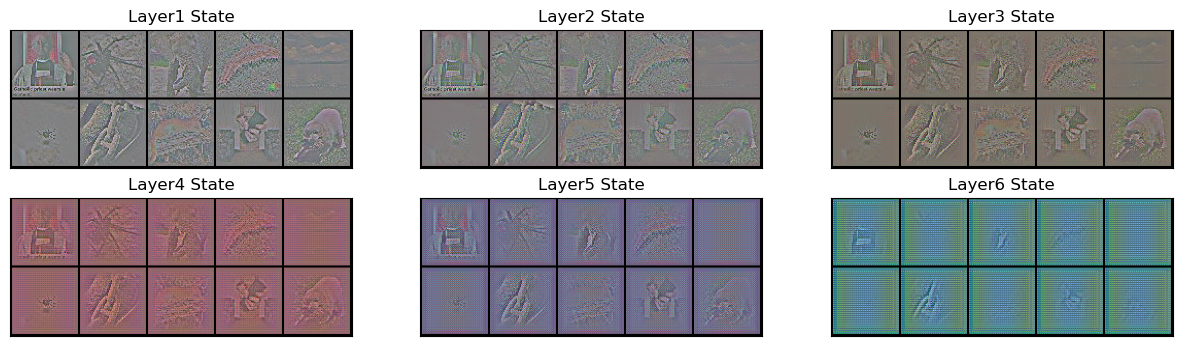

In [6]:
from torchvision.utils import make_grid

recon11 = torch.load('ML-CSC_recon_1.pt')[-10:]
recon11 = make_grid(recon11, nrow=5, normalize=True).cpu().numpy()

recon12 = torch.load('ML-CSC_recon_2.pt')[-10:]
recon12 = make_grid(recon12, nrow=5, normalize=True).cpu().numpy()

recon21 = torch.load('ML-CSC_recon_3.pt')[-10:]
recon21 = make_grid(recon21, nrow=5, normalize=True).cpu().numpy()

recon22 = torch.load('ML-CSC_recon_4.pt')[-10:]
recon22 = make_grid(recon22, nrow=5, normalize=True).cpu().numpy()

recon31 = torch.load('ML-CSC_recon_5.pt')[-10:]
recon31 = make_grid(recon31, nrow=5, normalize=True).cpu().numpy()

recon32 = torch.load('ML-CSC_recon_6.pt')[-10:]
recon32 = make_grid(recon32, nrow=5, normalize=True).cpu().numpy()


plt.figure(figsize=(15,4))
plt.tight_layout()
plt.subplot(2,3,1)
plt.imshow(np.transpose(recon11,[1,2,0]))
plt.title('Layer1 State')
plt.xticks([])
plt.yticks([])
plt.subplot(2,3,2)
plt.imshow(np.transpose(recon12,[1,2,0]))
plt.title('Layer2 State')
plt.xticks([])
plt.yticks([])
plt.subplot(2,3,3)
plt.imshow(np.transpose(recon21,[1,2,0]))
plt.title('Layer3 State')
plt.xticks([])
plt.yticks([])
plt.subplot(2,3,4)
plt.imshow(np.transpose(recon22,[1,2,0]))
plt.title('Layer4 State')
plt.xticks([])
plt.yticks([])
plt.subplot(2,3,5)
plt.imshow(np.transpose(recon31,[1,2,0]))
plt.title('Layer5 State')
plt.xticks([])
plt.yticks([])
plt.subplot(2,3,6)
plt.imshow(np.transpose(recon32,[1,2,0]))
plt.title('Layer6 State')
plt.xticks([])
plt.yticks([])
#plt.show()

plt.savefig('ML-CSC-imagenet-recon.pdf',bbox_inches='tight')

In [ ]:
import torchvision.transforms as T
import kornia as K
import torchvision.datasets as datasets
import os
from pathlib import Path
def tensor_to_pil(image_tensor):
    return T.ToPILImage()(image_tensor)

# Normalize whitened images into the range [0, 255]
def normalize_to_uint8(image_tensor):
    min_val = image_tensor.min()
    max_val = image_tensor.max()
    
    # Apply min-max normalization
    normalized = (image_tensor - min_val) / (max_val - min_val) * 255.0
    
    # Convert to uint8
    return normalized.byte()

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
zca = K.enhance.ZCAWhitening(eps=0.1, compute_inv=True)
state_dict = torch.load('data/tiny-imagenet-200/zca_model.pt')
zca.transform_matrix = state_dict['transform_matrix']
zca.transform_inv = state_dict['transform_inv']
zca.mean_vector = state_dict['mean_vector']
zca.fitted = state_dict['fitted']
zca = zca.to(device)

In [ ]:
data_type = 'val'
data_dir = f"data/tiny-imagenet-200/{data_type}"
transform_tiny = T.Compose([
    T.ToTensor(),  # Convert PIL image to tensor
])
tiny_imgnet = datasets.ImageFolder(
        f"data/tiny-imagenet-200/{data_type}",
        transform = transform_tiny)
batch_size = 32
tiny_loader = torch.utils.data.DataLoader(tiny_imgnet, batch_size=batch_size, shuffle=False)
save_dir = f"data/tiny-imagenet-200-MLCSC-L6/{data_type}"

model_dec = MLCSC6(6)
model_dec.cuda()

if not os.path.exists(save_dir):
    os.makedirs(save_dir)

for batch_idx, (images, labels) in enumerate(tiny_loader):
    if batch_idx % 100 == 0:
        print("Progress: {:.2f}%".format(100 * batch_idx / len(tiny_loader)))
    with torch.no_grad():
        img_batch = zca(images)
    img_batch = img_batch.to(device)
    labels = labels.to(device)
    
    with torch.no_grad():
        code = model_dec.initialize(img_batch)
        #code = torch.randn_like(code).cuda()

        sparse_code, loss_list = model_dec.FISTA(code, img_batch, lambd=0.03, n_iter=20)
        recon = model_dec(sparse_code)
    # save the results
    for i, image in enumerate(recon):
        original_file_path, _ = tiny_imgnet.samples[batch_idx*batch_size+i]
        image = normalize_to_uint8(image)
        u2_img_pil = tensor_to_pil(image.detach().cpu())
        # Get relative path to keep original folder structure
        relative_path = Path(original_file_path).relative_to(data_dir)
        # Create the target folder structure
        target_folder = Path(save_dir) / relative_path.parent
        target_folder.mkdir(parents=True, exist_ok=True)
        
        u2_img_pil.save(target_folder / f"{relative_path.stem}.JPEG")